# Adversarial Attacks

In Part 1, you will implement a simple adversarial attack on MNIST images. In the second part, you implement the same adversarial attack on CIFAR-10 images. In the third and final part, you will take a picture of an item you would expect to find in CIFAR-10 and use your trained model to generate an adversarial example.

**Imports:**

In [1]:
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [2]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole)

True


### Part 1: MNIST Attack

**Defining the model and optimizer**

In [3]:
## Defining the model:
class Net(nn.Module):
    def __init__(self, input_size, width, num_classes):
        super(Net, self).__init__()

        ##feedfoward layers:
        self.ff1 = nn.Linear(input_size, width) #input

        self.ff2 = nn.Linear(width, width) #hidden layers
        self.ff3 = nn.Linear(width, width)

        self.ff_out = nn.Linear(width, num_classes) #logit layer     

        ##activations:
        self.relu = nn.ReLU()
                
    def forward(self, input_data):
        out = self.relu(self.ff1(input_data)) 
        out = self.relu(self.ff2(out)) 
        out = self.relu(self.ff3(out))
        out = self.ff_out(out)
        return out #returns class probabilities for each image

net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()


**Data pipeline:**

In [5]:
#Downloading and unzipping MNIST data files:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  33360      0  0:04:57  0:04:57 --:--:-- 30922
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  72748      0 --:--:-- --:--:-- --:--:-- 72931
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  34183      0  0:00:48  0:00:48 --:--:-- 30920
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  11952      0 --:--:-- --:--:-- --:--:-- 11952


In [7]:
##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10     
        else:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')


xtrain = torch.Tensor(xtrain)
xtrain /= xtrain.max()
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest)
xtest /= xtest.max()
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


**Implement your adversarial attack here:**

In [44]:
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y_true, model):
            """
            
            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            Loss = self.loss(model(x), y_true)
            Loss.backward()
            sign = x.grad.data.sign()

            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to 
            # the original image
            # you might need to clamp the modified image to 
            # make sure the values of each pixel are between [0,1]
            output = x + self.epsilon * sign
            output = torch.clamp(output, 0, 1)
            return output

In [39]:
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [40]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total




**Training Loop:** Your adverarial accuracy will also be printed in the loop.

Starting Training
Epoch 1 :
Train accuracy: 90.008331 %
Train loss: 0.002695
Test accuracy: 89.959999 %
Test loss: 0.002650
Test accuracy adversarial: 28.430000 %
Test loss adversarial: 0.017839
Elapsed time for epoch: 10.644054889678955 s
ETA of completion: 1.5966082334518432 minutes



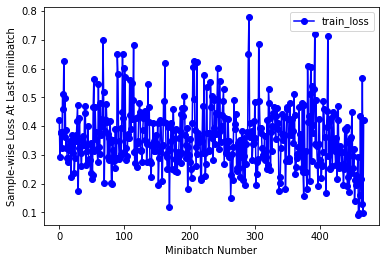

Epoch 2 :
Train accuracy: 90.675003 %
Train loss: 0.002526
Test accuracy: 90.660004 %
Test loss: 0.002489
Test accuracy adversarial: 27.629999 %
Test loss adversarial: 0.018391
Elapsed time for epoch: 10.653903722763062 s
ETA of completion: 1.4205204963684082 minutes



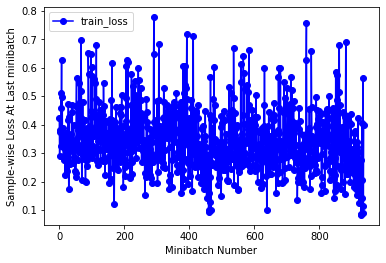

Epoch 3 :
Train accuracy: 91.258331 %
Train loss: 0.002383
Test accuracy: 91.129997 %
Test loss: 0.002352
Test accuracy adversarial: 26.969999 %
Test loss adversarial: 0.018812
Elapsed time for epoch: 10.566583156585693 s
ETA of completion: 1.2327680349349976 minutes



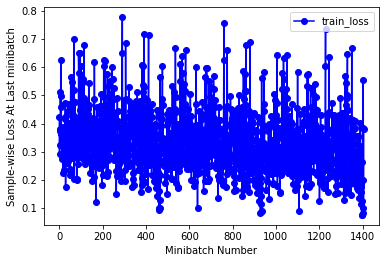

Epoch 4 :
Train accuracy: 91.713333 %
Train loss: 0.002254
Test accuracy: 91.639999 %
Test loss: 0.002230
Test accuracy adversarial: 26.209999 %
Test loss adversarial: 0.019150
Elapsed time for epoch: 10.390390157699585 s
ETA of completion: 1.0390390157699585 minutes



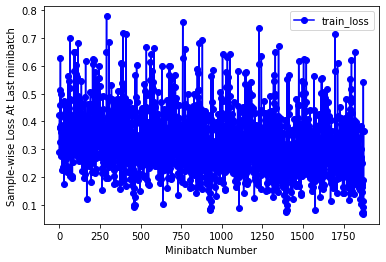

Epoch 5 :
Train accuracy: 92.154999 %
Train loss: 0.002137
Test accuracy: 92.099998 %
Test loss: 0.002119
Test accuracy adversarial: 25.740000 %
Test loss adversarial: 0.019444
Elapsed time for epoch: 10.371750593185425 s
ETA of completion: 0.8643125494321188 minutes



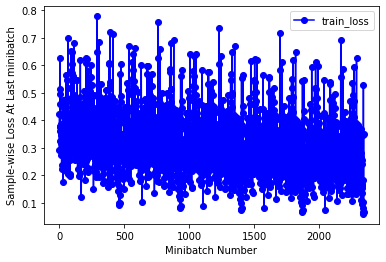

Epoch 6 :
Train accuracy: 92.550003 %
Train loss: 0.002028
Test accuracy: 92.589996 %
Test loss: 0.002016
Test accuracy adversarial: 25.440001 %
Test loss adversarial: 0.019697
Elapsed time for epoch: 10.266639709472656 s
ETA of completion: 0.684442647298177 minutes



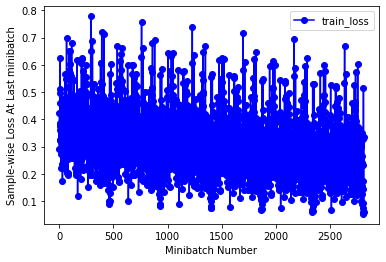

Epoch 7 :
Train accuracy: 92.941666 %
Train loss: 0.001925
Test accuracy: 92.849998 %
Test loss: 0.001918
Test accuracy adversarial: 25.049999 %
Test loss adversarial: 0.019933
Elapsed time for epoch: 10.544422149658203 s
ETA of completion: 0.5272211074829102 minutes



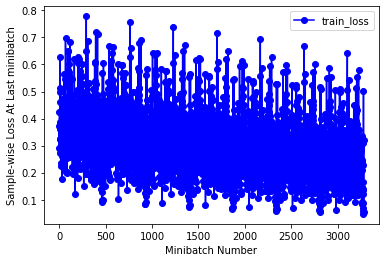

Epoch 8 :
Train accuracy: 93.315002 %
Train loss: 0.001829
Test accuracy: 93.239998 %
Test loss: 0.001827
Test accuracy adversarial: 24.930000 %
Test loss adversarial: 0.020157
Elapsed time for epoch: 10.661524057388306 s
ETA of completion: 0.3553841352462769 minutes



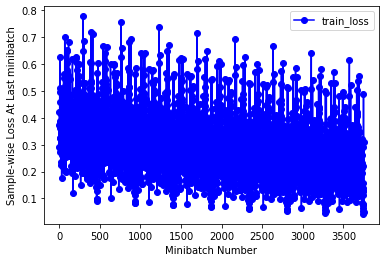

Epoch 9 :
Train accuracy: 93.628334 %
Train loss: 0.001739
Test accuracy: 93.510002 %
Test loss: 0.001741
Test accuracy adversarial: 24.629999 %
Test loss adversarial: 0.020386
Elapsed time for epoch: 10.468766689300537 s
ETA of completion: 0.17447944482167563 minutes



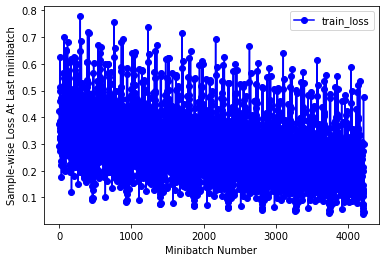

Epoch 10 :
Train accuracy: 93.955002 %
Train loss: 0.001655
Test accuracy: 93.820000 %
Test loss: 0.001660
Test accuracy adversarial: 24.309999 %
Test loss adversarial: 0.020625
Elapsed time for epoch: 10.38990068435669 s
ETA of completion: 0.0 minutes



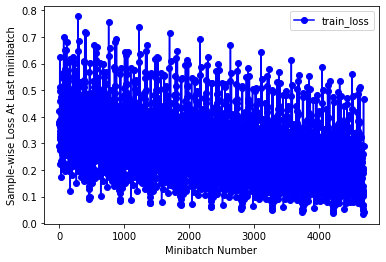

In [41]:
#number of epochs to train for:
epochs = 10

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(train_loader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        x = x.view(x.shape[0],-1)

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()

        if i > 0 or epoch > 0:
            loss_batch_store.append(loss.cpu().data.numpy().item())

        ##perform update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

Visualize Some Examples

Visualize a original Image and its corresponding adversarial example.

Print the prediction of the model for both of the images.

The adversarial sample should look similar to the original image and be easily and correctly classified by a human.

tensor([3])


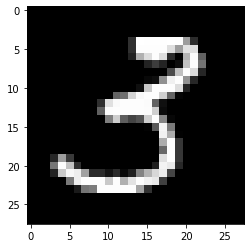

In [42]:
plt.imshow(x[0].cpu().reshape(28,28),cmap='gray')
print(net(x[0].view(-1,784)).argmax(dim=1))

tensor(5)


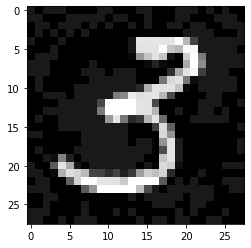

In [43]:
labels = net(x[0].view(-1,784)).argmax(dim=1)
in_x = Variable(x[[0]], requires_grad=True)
adv_x = adv_attack.forward(in_x, labels, net)
plt.imshow(adv_x[0].detach().cpu().reshape(28,28),cmap='gray')
print(net(adv_x[0].view(-1,784)).argmax(dim=1)[0])

### Part 2: CIFAR Attack

Now, you will attempt to use the same type of adversarial attack against a CIFAR classifier. You should use code structured similarly to that from above. We provide some struture below to get you started. We recommend trying the resnet50 model to begin, but feel free to experiment with model architectures and hyperparameters.

In [3]:
import torch
import torchvision
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms

In [4]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """
    
    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.fc = nn.Linear(2048, nclasses)
    else:
        model.classifier._modules['6'] = nn.Linear(4096, nclasses)
    return model

## Get Model
net = initialize_model(True, False, 10)
if gpu_boole:
  net = net.cuda()
# print(net)
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()

### TODO: Train the model using the same structure as before

In [15]:
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y_true, model):
            """
            
            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            Loss = self.loss(model(x), y_true)
            Loss.backward()
            sign = x.grad.data.sign()

            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to 
            # the original image
            # you might need to clamp the modified image to 
            # make sure the values of each pixel are between [0,1]
            output = x + self.epsilon * sign
            output = torch.clamp(output, 0, 1)
            return output


## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [13]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in trainloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        # images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        # images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        # images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total


Starting Training
Epoch 1 :
Train accuracy: 44.397999 %
Train loss: 0.011946
Test accuracy: 42.419998 %
Test loss: 0.012516
Test accuracy adversarial: 28.059999 %
Test loss adversarial: 0.016395
Elapsed time for epoch: 133.74686670303345 s
ETA of completion: 20.062030005455018 minutes



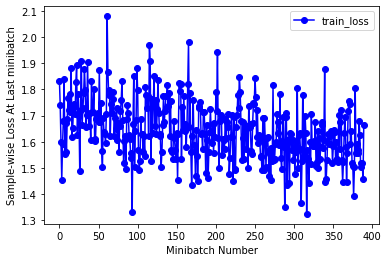

Epoch 2 :
Train accuracy: 48.256001 %
Train loss: 0.011062
Test accuracy: 45.730000 %
Test loss: 0.011821
Test accuracy adversarial: 26.469999 %
Test loss adversarial: 0.016802
Elapsed time for epoch: 133.86435890197754 s
ETA of completion: 17.84858118693034 minutes



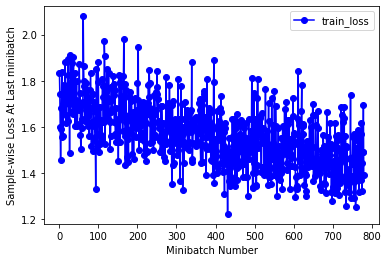

Epoch 3 :
Train accuracy: 54.723999 %
Train loss: 0.009769
Test accuracy: 49.250000 %
Test loss: 0.010954
Test accuracy adversarial: 28.900000 %
Test loss adversarial: 0.016692
Elapsed time for epoch: 134.5106201171875 s
ETA of completion: 15.692905680338542 minutes



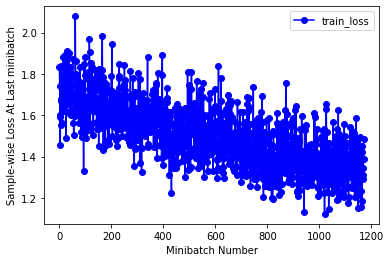

Epoch 4 :
Train accuracy: 57.717999 %
Train loss: 0.009241
Test accuracy: 51.439999 %
Test loss: 0.010773
Test accuracy adversarial: 26.859999 %
Test loss adversarial: 0.017895
Elapsed time for epoch: 134.39932012557983 s
ETA of completion: 13.439932012557984 minutes



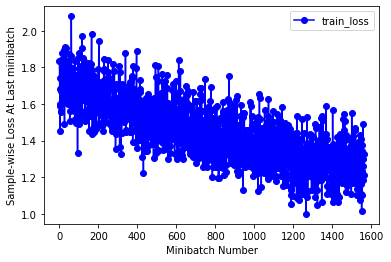

Epoch 5 :
Train accuracy: 55.084000 %
Train loss: 0.009753
Test accuracy: 48.389999 %
Test loss: 0.011787
Test accuracy adversarial: 26.219999 %
Test loss adversarial: 0.019572
Elapsed time for epoch: 134.6628782749176 s
ETA of completion: 11.2219065229098 minutes



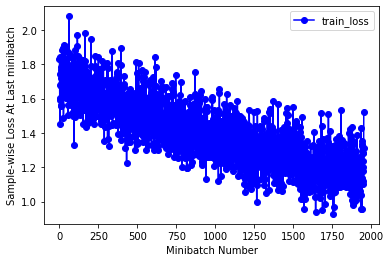

Epoch 6 :
Train accuracy: 62.930000 %
Train loss: 0.008187
Test accuracy: 52.779999 %
Test loss: 0.010813
Test accuracy adversarial: 27.240000 %
Test loss adversarial: 0.019185
Elapsed time for epoch: 134.38768219947815 s
ETA of completion: 8.959178813298543 minutes



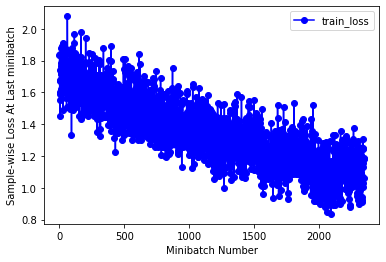

Epoch 7 :
Train accuracy: 67.481995 %
Train loss: 0.007156
Test accuracy: 54.520000 %
Test loss: 0.010411
Test accuracy adversarial: 27.959999 %
Test loss adversarial: 0.019563
Elapsed time for epoch: 134.63627886772156 s
ETA of completion: 6.7318139433860775 minutes



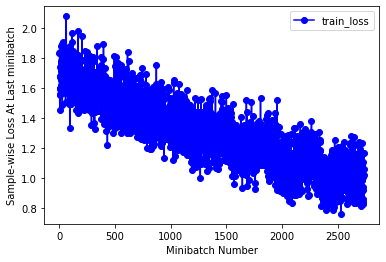

Epoch 8 :
Train accuracy: 71.367996 %
Train loss: 0.006308
Test accuracy: 55.389999 %
Test loss: 0.010250
Test accuracy adversarial: 26.609999 %
Test loss adversarial: 0.020143
Elapsed time for epoch: 134.61100888252258 s
ETA of completion: 4.48703362941742 minutes



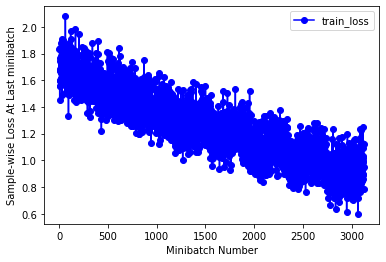

Epoch 9 :
Train accuracy: 75.529999 %
Train loss: 0.005479
Test accuracy: 56.660000 %
Test loss: 0.010317
Test accuracy adversarial: 27.789999 %
Test loss adversarial: 0.020942
Elapsed time for epoch: 133.93796968460083 s
ETA of completion: 2.232299494743347 minutes



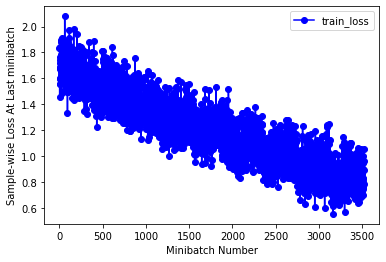

Epoch 10 :
Train accuracy: 79.089996 %
Train loss: 0.004681
Test accuracy: 56.689999 %
Test loss: 0.010667
Test accuracy adversarial: 28.269999 %
Test loss adversarial: 0.021987
Elapsed time for epoch: 133.17059206962585 s
ETA of completion: 0.0 minutes



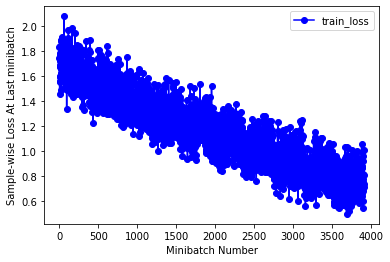

In [16]:
#number of epochs to train for:
epochs = 10

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(trainloader):
        
        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        # x = x.view(x.shape[0], x.shape[1], -1)
        # print(x.size())

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()

        if i > 0 or epoch > 0:
            loss_batch_store.append(loss.cpu().data.numpy().item())

        ##perform update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])
tensor(0, device='cuda:0')


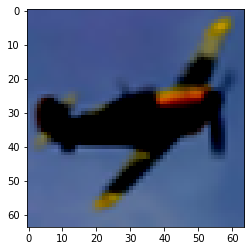

In [71]:
for _, (x, y) in enumerate(trainloader):
  img = torch.rand(64, 64, 3)
  for i in range(64):
    for j in range(64):
      for k in range(3):
        img[i][j][k] = x[0][k][i][j]
  
  x = x.cuda()
  print(x.size())
  # plt.imshow(x[0][0].cpu(), cmap='gray')
  plt.imshow(img.cpu())
  print(net(x).argmax(dim=1)[0])
  break

tensor(0, device='cuda:0')


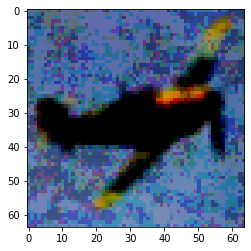

In [75]:
labels = net(x).argmax(dim=1)
in_x = Variable(x, requires_grad=True)
out_x = adv_attack.forward(in_x, labels, net)
adv_x = out_x[0]

img = torch.rand(64, 64, 3)
for i in range(64):
  for j in range(64):
    for k in range(3):
      img[i][j][k] = adv_x[k][i][j]
# plt.imshow(adv_x[0].detach().cpu(),cmap='gray')
plt.imshow(img.detach().cpu())
print(net(out_x).argmax(dim=1)[0])

### Part 3: Real World Example

Use your phone or other camera device to take a picture of an item you would find in CIFAR-10. Upload the photo to this notebook and format it so that it can be analyzed by your image classifier and the adversarial example generator.

In [ ]:
## Complete your work below

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
import matplotlib.image as mpimg

tensor(3, device='cuda:0')


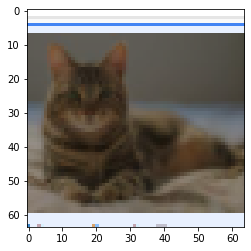

In [93]:
path = '/content/drive/MyDrive/Colab Notebooks/HW7_Spring2021/Adversarial_Examples/another_cat.png'
file = torch.from_numpy(mpimg.imread(path))
input = torch.rand(1, 3, 64, 64)
img = torch.rand(64, 64, 3)
for N in range(batch_size):
  for i in range(64):
    for j in range(64):
      for k in range(3):
        input[0][k][i][j] = file[i][j][k]
        img[i][j][k] = file[i][j][k]
plt.imshow(img.detach().cpu())

if gpu_boole:
  input = input.cuda()
print(net(input).argmax(dim=1)[0])

tensor(3, device='cuda:0')


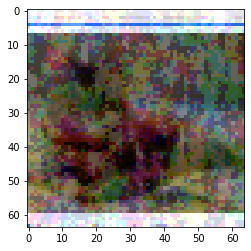

In [94]:
labels = net(input).argmax(dim=1)
in_x = Variable(input, requires_grad=True)
out_x = adv_attack.forward(in_x, labels, net)
adv_x = out_x[0]

img = torch.rand(64, 64, 3)
for i in range(64):
  for j in range(64):
    for k in range(3):
      img[i][j][k] = adv_x[k][i][j]
# plt.imshow(adv_x[0].detach().cpu(),cmap='gray')
plt.imshow(img.detach().cpu())
print(net(out_x).argmax(dim=1)[0])